In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as func

In [42]:
df= pd.read_pickle('Dataset/LSWMD.pkl')

In [52]:
df_copy=df.copy()

In [44]:
df=df_copy

In [45]:
df.head(7)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]
5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,6.0,[[Training]],[[none]]
6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,7.0,[[Training]],[[none]]


In [46]:
df['failureType']= df['failureType'].apply(lambda x: x[0][0] if len(x)>0 else 'Unknown')         #types of failures
df['trianTestLabel']= df['trianTestLabel'].apply(lambda x: x[0][0] if len(x)>0 else 'Unknown')   

defect_types= ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','none']
df_labeled = df[df['failureType'].isin(defect_types)]

print(f"Total labeled wafers: {len(df_labeled)}")
print(df_labeled['failureType'].value_counts())

Total labeled wafers: 172950
failureType
none         147431
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
Name: count, dtype: int64


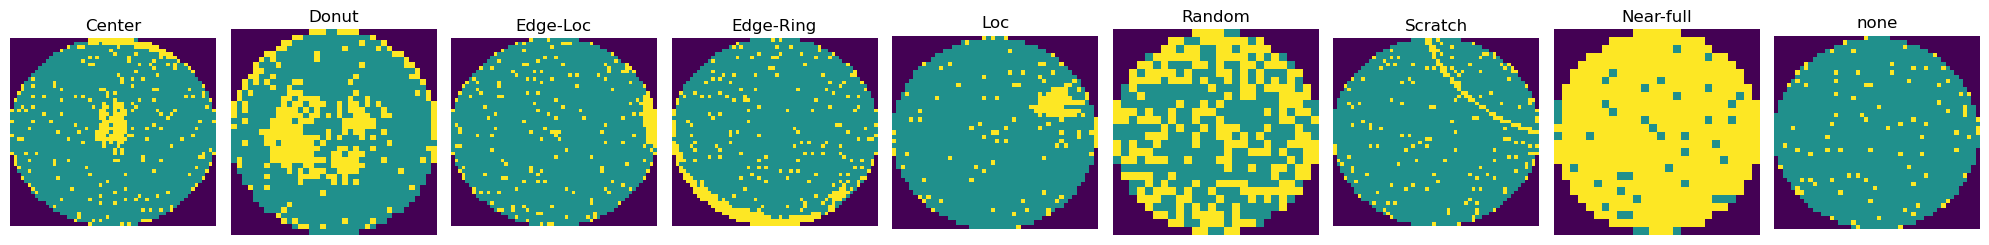

In [47]:
#Plotting 1st instance of all defects
fig,ax = plt.subplots(1,9,figsize=(20,5))
for i,defect in enumerate(defect_types):
    # 1st instance of each defect
    wafer= df_labeled[df_labeled['failureType']==defect].iloc[0]['waferMap']
    ax[i].imshow(wafer,cmap='viridis')
    ax[i].set_title(defect)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [48]:
from sklearn.preprocessing import LabelEncoder

encoder= LabelEncoder()

df_labeled['label_id']= encoder.fit_transform(df_labeled['failureType'])

label_mapping= dict(zip(encoder.classes_,encoder.transform(encoder.classes_)))
print("Class Mapping:", label_mapping)

Class Mapping: {'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3, 'Loc': 4, 'Near-full': 5, 'Random': 6, 'Scratch': 7, 'none': 8}


/var/folders/00/rfjj9nr57f13vcmft00bf6br0000gn/T/ipykernel_37612/3409723452.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled['label_id']= encoder.fit_transform(df_labeled['failureType'])


In [49]:
def resize_wafer(wafer_map, size=(26, 26)):
    return cv2.resize(wafer_map.astype(np.uint8),size,interpolation=cv2.INTER_NEAREST)

df_labeled['wafer_resized'] = df_labeled['waferMap'].apply(resize_wafer)

X = np.stack(df_labeled['wafer_resized'].values)        #(N, 26, 26)

#one hot encoding
X = np.eye(3)[X]        #(N, 26, 26, 3)

X = np.transpose(X, (0, 3, 1, 2)).astype(np.float32)        #CNN format

y = df_labeled['label_id'].values

print("X shape:", X.shape)   # (N, 3, 26, 26)
print("y shape:", y.shape)


/var/folders/00/rfjj9nr57f13vcmft00bf6br0000gn/T/ipykernel_37612/1425681819.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled['wafer_resized'] = df_labeled['waferMap'].apply(resize_wafer)


X shape: (172950, 3, 26, 26)
y shape: (172950,)


In [50]:
np.unique(X.sum(axis=1))


array([1.], dtype=float32)

In [51]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.25,random_state=23,stratify=y)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

Train shape: (129712, 3, 26, 26) (129712,)
Val shape: (43238, 3, 26, 26) (43238,)


In [54]:
#making splits to datasets and loaders
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)
#datasets
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t, y_val_t)
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [56]:
class WaferCNN(nn.Module):
    def __init__(self,num_classes):
        super(WaferCNN,self).__init__()

        self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(64*6*6,128)
        self.fc2=nn.Linear(128,num_classes)

    def forward(self,x):
        x=self.pool(func.relu(self.conv1(x)))
        x=self.pool(func.relu(self.conv2(x)))
        x=x.view(x.size(0),-1)      #flattens the 2d vector
        x=func.relu(self.fc1(x))
        x=self.fc2(x)
        return x

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)
class_counts= np.bincount(y_train)
class_weights= 1.0 / class_counts
class_weights= class_weights / class_weights.sum()

class_weights= torch.tensor(class_weights, dtype=torch.float32).to(device)
print(class_weights)


device: cpu
tensor([0.0206, 0.1594, 0.0170, 0.0091, 0.0246, 0.5922, 0.1022, 0.0741, 0.0006])


In [60]:
num_classes= len(np.unique(y))
model= WaferCNN(num_classes).to(device)
criterion= nn.CrossEntropyLoss(weight=class_weights)
optimizer= torch.optim.Adam(model.parameters(),lr=1e-3)


In [61]:
def train_model(model, train_loader, val_loader, epochs=15):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)

            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                outputs = model(Xb)
                _, preds = torch.max(outputs, 1)

                total += yb.size(0)
                correct += (preds == yb).sum().item()

        val_acc = correct / total

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Accuracy: {val_acc:.4f}"
        )


In [62]:
train_model(model, train_loader, val_loader, epochs=15)


Epoch [1/15] | Train Loss: 0.9108 | Val Accuracy: 0.9367
Epoch [2/15] | Train Loss: 0.5752 | Val Accuracy: 0.8738
Epoch [3/15] | Train Loss: 0.4795 | Val Accuracy: 0.8690
Epoch [4/15] | Train Loss: 0.4179 | Val Accuracy: 0.8831
Epoch [5/15] | Train Loss: 0.3714 | Val Accuracy: 0.8712
Epoch [6/15] | Train Loss: 0.3105 | Val Accuracy: 0.8079
Epoch [7/15] | Train Loss: 0.2710 | Val Accuracy: 0.8621
Epoch [8/15] | Train Loss: 0.2320 | Val Accuracy: 0.7471
Epoch [9/15] | Train Loss: 0.2039 | Val Accuracy: 0.8522
Epoch [10/15] | Train Loss: 0.1709 | Val Accuracy: 0.8965
Epoch [11/15] | Train Loss: 0.1535 | Val Accuracy: 0.9040
Epoch [12/15] | Train Loss: 0.1288 | Val Accuracy: 0.8593
Epoch [13/15] | Train Loss: 0.1166 | Val Accuracy: 0.9187
Epoch [14/15] | Train Loss: 0.1108 | Val Accuracy: 0.8780
Epoch [15/15] | Train Loss: 0.0968 | Val Accuracy: 0.8986
